# **End to End CNN with Tensorflow Transfer Learning Feature Extraction**

# What I'm going to cover
* Transfer Learning with TensorFlow
* Using a small dataset to experiment faster(10% of training samples)
* Building a transfer learning feature extraction model with TensorFlow Hub
* Use TensforBoard to track modelling experiments and results

In [1]:
# Using a GPU
!nvidia-smi

Mon Sep 11 06:47:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Sourcing the dataset( 10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-11 06:50:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2023-09-11 06:50:48 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# How many images are in the directories
import os

# Walk throught 10 percent of data directory and list number of file
for dirpath, dirnames , filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

### Create data loaders (preparing the data)
* use the `ImageDataGenerator` class to load in our images in batches

In [9]:
# Setup the data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

test_data_10_percet = test_datagen.flow_from_directory(test_dir,
                                                       target_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')

Training Images
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up the callback
* Use TensorBoard to track the experiments

In [53]:
# Create a function to build a tensorflow callback
import datetime # import to know when the model was run

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensoboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensoboard_callback



### Accessing pretrained models in tensorflow hub
I'm going to be using the **efficientnet/b0/feature-vector**

In [14]:
# Compare the models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
# Import dependancies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [37]:
# Create model function from url

def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and create a Keras Sequential modle with it.
  Args:
    model_url (str): A TensoFlow Hub features extraction url.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10,
  Returns:
    An uncompiled Keras Sequential layer model with model_url as feature extractor layer and Dense output layer with num_classes output Neurons.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # freeze the already learned patterns
                                          name='feature_extraction_layer',
                                          input_shape=IMAGE_SHAPE+(3,))

  # Create  the model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model


### Create and test TensorFlow Hub Feature Extraction Model

In [38]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [39]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [40]:
# Compile our model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [55]:
# Fit the model
from tensorflow.keras.callbacks import Callback
resnet_history =resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch= len(train_data_10_percent),
                                 validation_data = test_data_10_percet,
                                 validation_steps= len(test_data_10_percet),
                                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                        experiment_name='resnet50v2')])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20230911-083707
Epoch 1/5
24/24 [==============================] - 25s 526ms/step - loss: 1.9112 - accuracy: 0.3800 - val_loss: 1.2174 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 10s 442ms/step - loss: 0.9021 - accuracy: 0.7293 - val_loss: 0.8519 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 10s 437ms/step - loss: 0.6216 - accuracy: 0.8213 - val_loss: 0.7595 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 10s 435ms/step - loss: 0.4756 - accuracy: 0.8840 - val_loss: 0.7157 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 10s 430ms/step - loss: 0.3853 - accuracy: 0.9053 - val_loss: 0.6782 - val_accuracy: 0.7844


## Plot the loss curve of the Transfer Learning

In [59]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [60]:
# Plot the validation and training curves separately
def plot_loss_curve(history):
  """
  Returns separate loss curves for training and validation metrics. (This is also possible by use of callbacks)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot the accuray
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

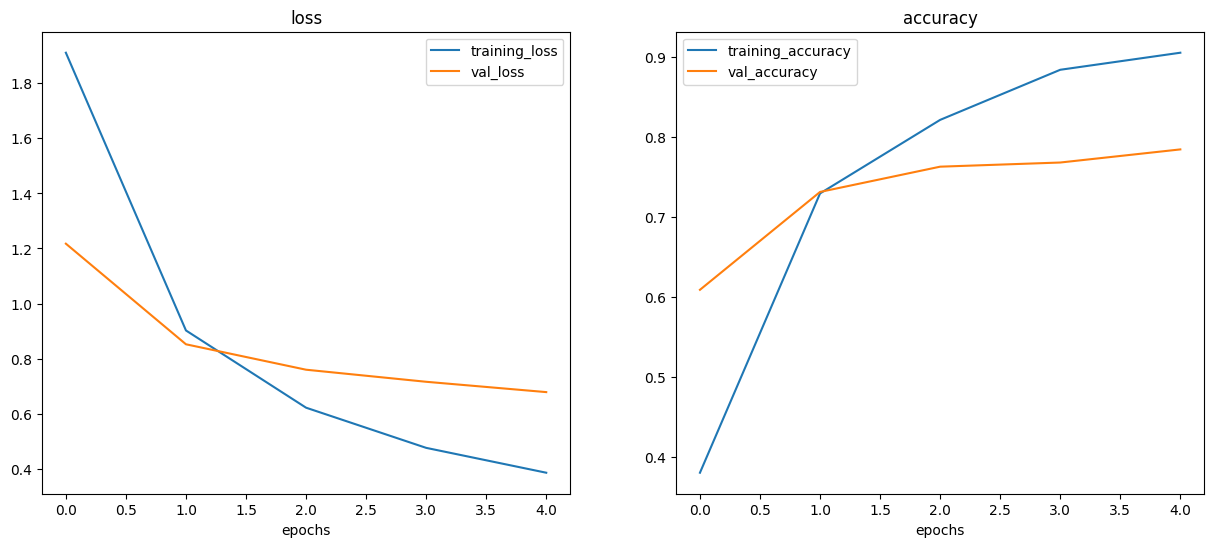

In [61]:
# Plot the curves
plot_loss_curve(history=resnet_history)

**Deductions:**

The transfer learning model surpasses the previous CNN networks in terms of performance. Despite being trained on only 10% of the original dataset, it exhibits significantly faster training times and attains a superior level of accuracy.

### Creating and testing the EfficeintNetB0 TensorFlow Hub Features Extraction Model

In [64]:
efficientnet_model = create_model(efficient_url,
                                   num_classes=train_data_10_percent.num_classes)

In [73]:
# Compile the model
efficient_net_model.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=['accuracy'])


In [75]:
# Fit the model
history_efficient = efficient_net_model.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percet,
                        validation_steps = len(test_data_10_percet),
                        callbacks=[create_tensorboard_callback(dir_name="TensorFlow Hub",
                                                               experiment_name="EfficientNet")])

Saving TensorBoard log files to : TensorFlow Hub/EfficientNet/20230911-090845
Epoch 1/5
24/24 [==============================] - 11s 428ms/step - loss: 0.4387 - accuracy: 0.9093 - val_loss: 0.5231 - val_accuracy: 0.8704
Epoch 2/5
24/24 [==============================] - 11s 467ms/step - loss: 0.3873 - accuracy: 0.9320 - val_loss: 0.4969 - val_accuracy: 0.8700
Epoch 3/5
24/24 [==============================] - 10s 413ms/step - loss: 0.3426 - accuracy: 0.9413 - val_loss: 0.4745 - val_accuracy: 0.8748
Epoch 4/5
24/24 [==============================] - 10s 425ms/step - loss: 0.3094 - accuracy: 0.9467 - val_loss: 0.4605 - val_accuracy: 0.8744
Epoch 5/5
24/24 [==============================] - 10s 435ms/step - loss: 0.2789 - accuracy: 0.9573 - val_loss: 0.4470 - val_accuracy: 0.8740


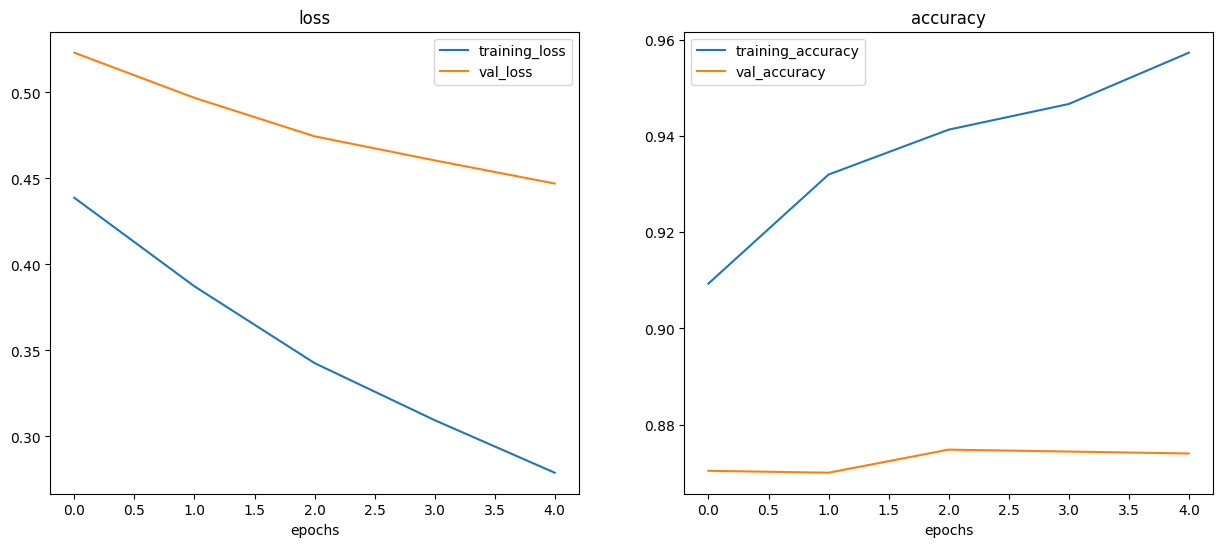

In [76]:
plot_loss_curve(history=history_efficient)

**Deductions**

The pretrained EfficientNet model outperforms other models when it comes to accuracy while also being more time-efficient. This can be particularly advantageous for tasks where both accuracy and computational efficiency are critical, making EfficientNet a compelling choice for various machine learning applications.

The image below is shows how diffrent transfer learnign models perform and how they compare to each other in terms of accuracy and number of paramerters.

*Image source:* https://wisdomml.in/efficientnet-and-its-performance-comparison-with-other-transfer-learning-networks/

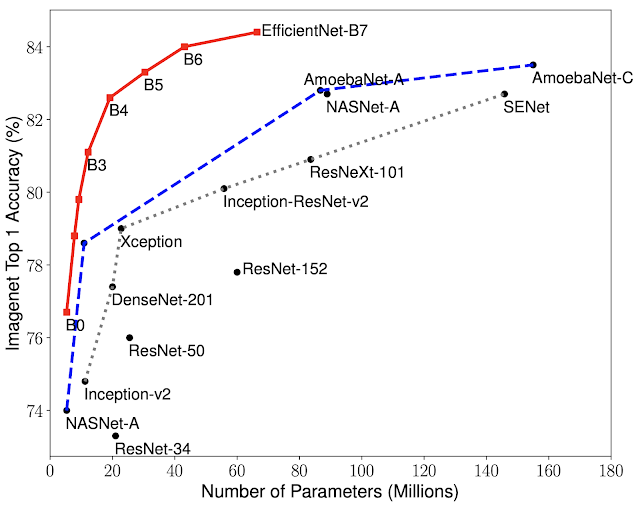

In [77]:
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [78]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [82]:
# Layers in efficientnet and in resnet
efficient_net_model.layers, resnet_model.layers

([<tensorflow_hub.keras_layer.KerasLayer at 0x7d0bdb16a500>,
  <keras.src.layers.core.dense.Dense at 0x7d0c0e1c1930>])

## Comparing the Models results using TensorBoard

In [ ]:
# Upload TensorBoad deve records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

*Public TensorBoard link:* https://tensorboard.dev/experiment/Fz5J9pY9QV62042LamsMBg/

In [90]:
# Check the TensorBoard experiments
!tensorboard dev list

2023-09-11 09:53:10.170013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/Fz5J9pY9QV62042LamsMBg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   Fz5J9pY9QV62042LamsMBg
	Created              2023-09-11 09:47:03 (6 minutes ago)
	Updated              2023-09-11 09:47:04 (6 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1876964
Total: 1 experiment(s)
